# Práctica 10: AEs

En esta práctica usaremos un autoencoder como detector de anomalías. Para ello entrenaremos un autoenconder con un conjunto de imágenes de radiografias de tórax de individuos sanos y consideraremos como anomalías las radiografías de individuos con neumonía

In [19]:
!pip install torch numpy matplotlib scikit-image cython setuptools medmnist

In [20]:
### EVITAR ERRORES

!uv pip install -q --system numba-cuda==0.4.0

from numba import config
config.CUDA_ENABLE_PYNVJITLINK = 1

In [21]:
import numpy as np
print(np.__version__)

2.0.2


## Dataset

Usaremos un subconjunto de [__MedMNIST__](https://medmnist.com/): un dataset con diversos conjuntos de datos de imágenes médicas. En concreto usaremos __PneumoniaMNIST__, que tiene las siguientes características:
- Más de 5000 imágenes divididas en conjuntos de training, validation y testing.
- Imágenes monocromas de 28x28 píxeles
- Directamente utilizable desde pytorch
- Cada imagen tiene una etiqueta asociada que indica si la imagen es de un individuo sano o con neumonía.

Para poder utilizar el dataset, primero deberemos instalar el paquete medmnist: ``pip install medmnist``

A continuación se incluye un código python que permite un acceso básico al dataset y muestra mosaicos de imágenes de individuos sanos y con neumonía.

In [22]:
import medmnist
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset, Subset
import matplotlib.pyplot as plt
from collections import Counter
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns


print(medmnist.__version__)
from medmnist import PneumoniaMNIST

3.0.2


In [23]:
# Información del dataset
download = True
info = medmnist.INFO['pneumoniamnist']
print(info)

# Obtener la clase de datos
DataClass = getattr(medmnist, info['python_class'])

# Transformaciones de imagen
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Cargar dataset
train_dataset = DataClass(split='train', transform=transform, download=download)

healthy_images = []
pneumonia_images = []

for img, label in train_dataset:
    if label.item() == 0:
        healthy_images.append(img.squeeze())  # quitar dimensión del canal
    if len(healthy_images) == 12:
        break

for img, label in train_dataset:
    if label.item() == 1:
        pneumonia_images.append(img.squeeze())
    if len(pneumonia_images) == 12:
        break

{'python_class': 'PneumoniaMNIST', 'description': 'The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.', 'url': 'https://zenodo.org/records/10519652/files/pneumoniamnist.npz?download=1', 'MD5': '28209eda62fecd6e6a2d98b1501bb15f', 'url_64': 'https://zenodo.org/records/10519652/files/pneumoniamnist_64.npz?download=1', 'MD5_64': '8f4eceb4ccffa70c672198ea285246c6', 'url_128': 'https://zenodo.org/records/10519652/files/pneumoniamnist_128.npz?download=1', 'MD5_128': '05b46931834c231683c68f40c47b2971', 'url_224': 'https://zenodo.org/records/10519652/files/pneumoniamnist_224.npz?download=1', 'MD5_224': 'd6a3c71de1b945ea11211b

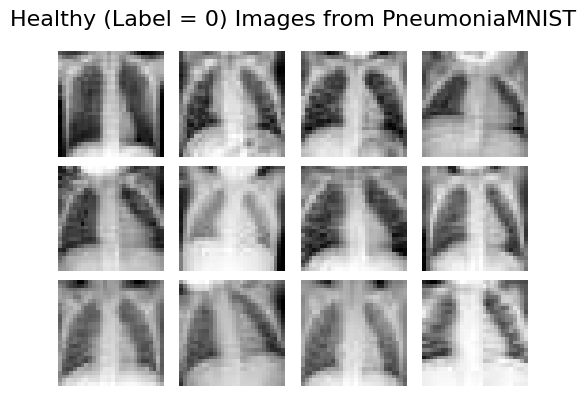

In [24]:
# Crear mosaico de imágenes sanas
fig, axes = plt.subplots(3, 4, figsize=(5, 4))
fig.suptitle("Healthy (Label = 0) Images from PneumoniaMNIST", fontsize=16)
for i, ax in enumerate(axes.flat):
    ax.imshow(healthy_images[i], cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

Obsérvese que el dataset estará compuesto de todas las imágenes, y que para distinguirlas habrá que hacer uso de la etiqueta asociada a cada imagen.

## Modelo

Se probarán las prestaciones de modelos autoencoders estándar (AE) y variacionales (VAE). Como punto de partida se propone la estructura propuesta en el paper disponible en el siguiente [enlace](https://essay.utwente.nl/98159/1/Reve_BA_EEMCS.pdf)

Obsérvese en la fig. 6 del paper la estructura del autoencoder utilizado, en la cual el _bottleneck_ es de tamaño 4x4x8 = 128 sin aplanar

## Tareas a realizar en la práctica



### **1. Estudiar las características del dataset y plantear un marco experimental adecuado: entrenar con las imágenes del conjunto de training de individuos sanos y usar un conjunto de validación y otro de test balanceados (mismo número de imágenes de individuos sanos y con neumonía)**

🎯 Objetivo: Entrenar un modelo con datos solo de personas sanas (label = 0), para que luego podamos ver si detecta las imágenes "raras", es decir, con neumonía (label = 1).

Esto se parece a lo que se llama un sistema de detección de anomalías, o más formalmente: one-class classification.

✅ Entrenamiento:
Solo usaremos las imágenes de entrenamiento con label = 0.

🔄 Validación y test:
Usaremos conjuntos balanceados: igual número de imágenes sanas y con neumonía, para ver cómo el modelo se comporta con ambos tipos.

#### **Características** del dataset `PneumoniaMNIST`

In [25]:
# Función para mostrar info
def show_info(nombre, dataset):
    labels = [label.item() for _, label in dataset]
    class_counts = Counter(labels)
    print(f"\n--- {nombre.upper()} ---")
    for k, v in class_counts.items():
        print(f"Clase {k}: {v} imágenes")
    sample_img, _ = dataset[0]
    print(f"Tamaño de imagen: {sample_img.shape}")

In [26]:
# Inicializa datasets
train_dataset = PneumoniaMNIST(split='train', transform=transform, download=True)
val_dataset   = PneumoniaMNIST(split='val', transform=transform, download=True)
test_dataset  = PneumoniaMNIST(split='test', transform=transform, download=True)

# Mostrar info para cada split
show_info("Train", train_dataset)
show_info("Validation", val_dataset)
show_info("Test", test_dataset)


--- TRAIN ---
Clase 1: 3494 imágenes
Clase 0: 1214 imágenes
Tamaño de imagen: torch.Size([1, 28, 28])

--- VALIDATION ---
Clase 1: 389 imágenes
Clase 0: 135 imágenes
Tamaño de imagen: torch.Size([1, 28, 28])

--- TEST ---
Clase 1: 390 imágenes
Clase 0: 234 imágenes
Tamaño de imagen: torch.Size([1, 28, 28])


Este dataset contiene imágenes médicas (radiografías torácicas) preprocesadas y etiquetadas como:

* 0: Sano

* 1: Con neumonía

Son imágenes en escala de grises (1 canal) y tamaño fijo: 28x28 píxeles.


#### Definir **variational autoencoder**

In [27]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),   # -> [B, 16, 28, 28]
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),                    # -> [B, 16, 14, 14]

            nn.Conv2d(16, 8, kernel_size=3, padding=1),   # -> [B, 8, 14, 14]
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),                    # -> [B, 8, 7, 7]

            nn.Conv2d(8, 8, kernel_size=3, padding=1),    # -> [B, 8, 7, 7]
            nn.ReLU(),
            nn.MaxPool2d(2, stride=1)                     # -> [B, 8, 6, 6]
        )

        # Capa para calcular la media y log-variancia
        self.fc_mu = nn.Linear(8 * 6 * 6, 128)   # Media del espacio latente
        self.fc_logvar = nn.Linear(8 * 6 * 6, 128)  # Log de la varianza

        # Decoder
        self.decoder_fc = nn.Linear(128, 8 * 6 * 6)  # Decodificador
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 8, kernel_size=2, stride=2),     # -> [B, 8, 12, 12]
            nn.ReLU(),
            nn.ConvTranspose2d(8, 8, kernel_size=2, stride=2),     # -> [B, 8, 24, 24]
            nn.ReLU(),
            nn.ConvTranspose2d(8, 16, kernel_size=2, stride=2),    # -> [B, 16, 48, 48]
            nn.ReLU(),
            nn.Conv2d(16, 1, kernel_size=5, padding=2),            # -> [B, 1, 48, 48]
            nn.Upsample(size=(28, 28), mode='bilinear'),          # Asegura tamaño de salida
            nn.Sigmoid()
        )

    def encode(self, x):
        # Pasamos por el encoder
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Aplanamos la salida
        mu = self.fc_mu(x)  # Media
        logvar = self.fc_logvar(x)  # Log de la varianza
        return mu, logvar

    def reparameterize(self, mu, logvar):
        # Reparameterization trick
        std = torch.exp(0.5 * logvar)  # Convertimos logvar a std
        eps = torch.randn_like(std)  # Muestreamos epsilon
        return mu + eps * std  # Generamos el espacio latente

    def decode(self, z):
        # Decodificador
        z = self.decoder_fc(z)
        z = z.view(z.size(0), 8, 6, 6)  # Volvemos a dar forma a la salida
        return self.decoder(z)

    def forward(self, x):
        # Pass hacia adelante
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        decoded = self.decode(z)
        return decoded, mu, logvar


#### Función de **pérdida** para el VAE

In [28]:
# Función de pérdida
def vae_loss(recon_x, x, mu, logvar):

    # Error de reconstrucción
    BCE = F.binary_cross_entropy(recon_x.view(-1, 28 * 28), x.view(-1, 28 * 28), reduction='sum')

    # Divergencia KL
    MSE = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + MSE

#### **Entrenar** autoencoder

In [29]:
### ENTRENAMIENTO SOLO CON IMÁGENES SANAS
# Obtener imágenes sanas (label == 0)
healthy_images = [img for img, label in train_dataset if label.item() == 0]
healthy_tensor = torch.stack(healthy_images)

# Dataset y dataloader
healthy_dataset = TensorDataset(healthy_tensor)
train_loader = DataLoader(healthy_dataset, batch_size=64, shuffle=True)


#### Creamos **conjuntos balanceados** de val y test

In [30]:
# Función que produce datasets balanceados
def get_balanced_subset(dataset):
    labels = [label.item() for _, label in dataset]
    class_counts = Counter(labels)
    current_min = -1
    for k, v in class_counts.items():
        if current_min == -1:
            current_min = v
        else:
            current_min = min(current_min, v)

    n = current_min

    healthy = [ (img, label) for img, label in dataset if label.item() == 0 ][:n]
    pneumonia = [ (img, label) for img, label in dataset if label.item() == 1 ][:n]

    return healthy + pneumonia, n

balanced_val, n_val = get_balanced_subset(val_dataset)
balanced_test, n_test = get_balanced_subset(test_dataset)

print(f"Subconjunto validación: {len(balanced_val)} imágenes ({n_val} sanos + {n_val} con neumonía)")
print(f"Subconjunto test: {len(balanced_test)} imágenes ({n_test} sanos + {n_test} con neumonía)")


Subconjunto validación: 270 imágenes (135 sanos + 135 con neumonía)
Subconjunto test: 468 imágenes (234 sanos + 234 con neumonía)


#### Transformar a **`TensorDataset`** (evita errores)

In [31]:
# Función para pasar de lista de tuplas a TensorDataset
def list_to_tensor_dataset(data_list):
    imgs = torch.stack([img for img, _ in data_list])
    labels = torch.tensor([label for _, label in data_list])
    return TensorDataset(imgs, labels)


#### **Preparación** autoencoder

In [32]:
## DATOS
# Dataset de entrenamiento con solo imágenes sanas
healthy_train_indices = [i for i, (_, label) in enumerate(train_dataset) if label.item() == 0]
healthy_train_subset = Subset(train_dataset, healthy_train_indices)
train_loader = DataLoader(healthy_train_subset, batch_size=64, shuffle=True)

# Arreglar val y test
val_dataset_bal = list_to_tensor_dataset(balanced_val)
test_dataset_bal = list_to_tensor_dataset(balanced_test)

# Loaders correctos
val_loader = DataLoader(val_dataset_bal, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset_bal, batch_size=64, shuffle=False)

#### **Entrenamiento** autoencoder

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Inicialización de modelo, optimizador y loss function
vae = VAE().to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
num_epochs = 200

# Entrenamiento
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data)
        loss = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f"Train Epoch: {epoch} \tLoss: {train_loss / len(train_loader.dataset)}")

# Validación
def validate():
    vae.eval()
    val_loss = 0
    with torch.no_grad():
        for data, _ in val_loader:
            data = data.to(device)
            recon_batch, mu, logvar = vae(data)
            val_loss += vae_loss(recon_batch, data, mu, logvar).item()
    val_loss /= len(val_loader.dataset)
    print(f"Validation Loss: {val_loss}")

# Entrenamiento
for epoch in range(1, num_epochs + 1):
    train(epoch)
    validate()


Train Epoch: 1 	Loss: 540.866624407949
Validation Loss: 537.1332049334491
Train Epoch: 2 	Loss: 539.3694269975289
Validation Loss: 537.19609375
Train Epoch: 3 	Loss: 538.8164448620264
Validation Loss: 536.1902615017361
Train Epoch: 4 	Loss: 536.0169732032537
Validation Loss: 530.0725423177083
Train Epoch: 5 	Loss: 526.044038624897
Validation Loss: 524.0979727285879
Train Epoch: 6 	Loss: 519.975220732084
Validation Loss: 521.6557816116898
Train Epoch: 7 	Loss: 516.9502837983937
Validation Loss: 520.4124927662037
Train Epoch: 8 	Loss: 515.5300578536861
Validation Loss: 519.7522569444444
Train Epoch: 9 	Loss: 514.555828163612
Validation Loss: 519.1778085214121
Train Epoch: 10 	Loss: 513.395001029654
Validation Loss: 518.4007631655093
Train Epoch: 11 	Loss: 512.7580779576812
Validation Loss: 517.3221987123843
Train Epoch: 12 	Loss: 512.3266867020182
Validation Loss: 517.7019205729167
Train Epoch: 13 	Loss: 512.0882204360585
Validation Loss: 516.3769332320602
Train Epoch: 14 	Loss: 511.5471

### **2. Sobre el conjunto de validación, hacer un estudio de la distribución de los errores (media y desviación de los errores, histograma o nube de puntos como en la fig. 5 del paper) y obtener el umbral que minimiza el error de reconocimiento**

#### Calcular **errores por muestra**

In [37]:
# Cálculo de errores de reconstrucción sobre validación
vae.eval()
errors = []
labels = []

with torch.no_grad():
    for imgs, lbls in val_loader:
        imgs = imgs.to(device)
        recon_imgs, mu, logvar = vae(imgs)

        # Sólo el término de reconstrucción: BCEloss por píxel, luego media por muestra
        bce = F.binary_cross_entropy(
            recon_imgs.view(-1, 28*28),
            imgs.view(-1, 28*28),
            reduction='none'
        )  # [B, 28*28]
        bce = bce.mean(dim=1)    # [B]

        errors.extend(bce.cpu().numpy())
        labels.extend(lbls.numpy())

errors = np.array(errors)
labels = np.array(labels)

Calcular **estadísticas**

In [38]:
errors = np.array(errors).flatten()
labels = np.array(labels).flatten()

error_normal = errors[labels == 0]
error_anomaly = errors[labels == 1]

mean_normal = np.mean(error_normal)
std_normal = np.std(error_normal)

print(f"Media (normales): {mean_normal:.4f}")
print(f"Desviación estándar (normales): {std_normal:.4f}")
print(f"Media (anomalías): {np.mean(error_anomaly):.4f}")
print(f"Desviación estándar (anomalías): {np.std(error_anomaly):.4f}")


Media (normales): 0.6305
Desviación estándar (normales): 0.0270
Media (anomalías): 0.6526
Desviación estándar (anomalías): 0.0253


#### Graficar **figura** (tipo paper)

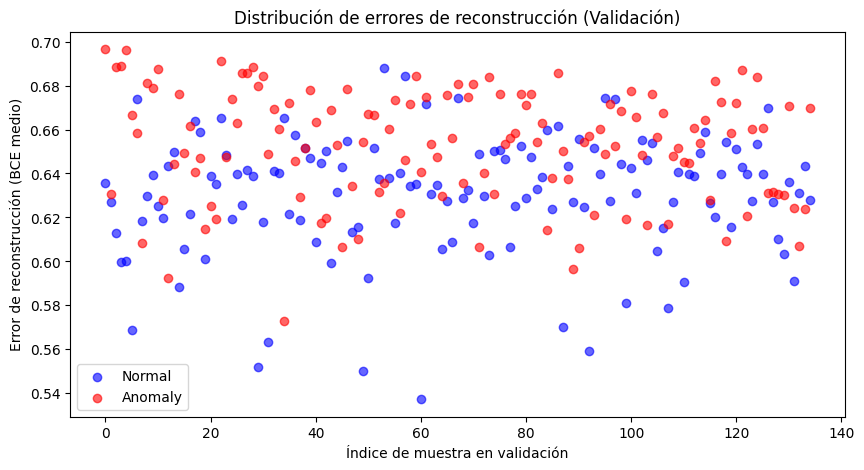

In [39]:
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(error_normal)),  error_normal,  label='Normal', color = 'Blue', marker='o', alpha=0.6)
plt.scatter(np.arange(len(error_anomaly)), error_anomaly, label='Anomaly', color = 'Red', marker='o', alpha=0.6)
plt.xlabel("Índice de muestra en validación")
plt.ylabel("Error de reconstrucción (BCE medio)")
plt.title("Distribución de errores de reconstrucción (Validación)")
plt.legend()
plt.show()


#### Mejor **umbral** (maximizando accuracy)

In [40]:
thresholds = np.linspace(errors.min(), errors.max(), 200)
best_acc, best_th = 0, 0

for th in thresholds:
    preds = (errors > th).astype(int)
    acc = accuracy_score(labels, preds)
    if acc > best_acc:
        best_acc, best_th = acc, th

print(f"\n🔍 Mejor umbral: {best_th:.4f}  —  Accuracy: {best_acc:.4f}")


🔍 Mejor umbral: 0.6517  —  Accuracy: 0.7000


### **3. Con este umbral, calcular las prestaciones del detector de anomalías sobre el conjunto de test. Calcular también probabilidad de falsos positivos y de falsos negativos.**

#### Evaluación sobre **conjunto de test**

In [41]:
# Evaluar sobre conjunto de test
vae.eval()
test_errors = []
test_labels = []

with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs = imgs.to(device)
        recon_imgs, mu, logvar = vae(imgs)

        # Sólo el término de reconstrucción: BCEloss por píxel, luego media por muestra
        bce = F.binary_cross_entropy(
            recon_imgs.view(-1, 28*28),
            imgs.view(-1, 28*28),
            reduction='none'
        )  # [B, 28*28]
        bce = bce.mean(dim=1)    # [B]

        test_errors.extend(bce.cpu().numpy())
        test_labels.extend(lbls.numpy())

# Convertir a array
test_errors = np.array(test_errors).flatten()
test_labels = np.array(test_labels).flatten()

# Predicciones: 1 si el error supera el umbral (anomalía), 0 si no
test_preds = (test_errors > best_th).astype(int)

# Accuracy global
acc_test = accuracy_score(test_labels, test_preds)
print(f"✅ Accuracy en test: {acc_test:.4f}")

✅ Accuracy en test: 0.7115


#### **Matriz de confusión**

🚨 Tasa de falsos positivos (FP rate): 0.2179
⚠️ Tasa de falsos negativos (FN rate): 0.3590


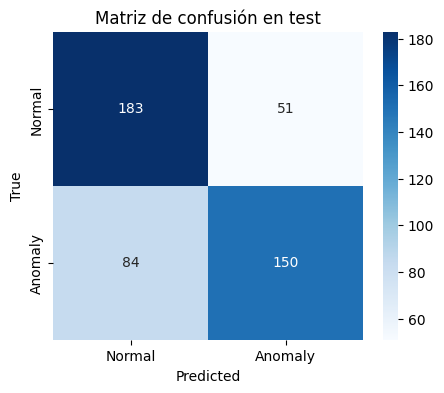

In [42]:
# Matriz de confusión
cm = confusion_matrix(test_labels, test_preds)
tn, fp, fn, tp = cm.ravel()

# Cálculo de tasas
fp_rate = fp / (fp + tn)
fn_rate = fn / (fn + tp)

print(f"🚨 Tasa de falsos positivos (FP rate): {fp_rate:.4f}")
print(f"⚠️ Tasa de falsos negativos (FN rate): {fn_rate:.4f}")

# (Opcional) Mostrar matriz de confusión
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Normal", "Anomaly"], yticklabels=["Normal", "Anomaly"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Matriz de confusión en test")
plt.show()

In [44]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Evaluar sobre conjunto de test
vae.eval()
test_errors = []
test_labels = []

with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs = imgs.to(device)
        recon_imgs, mu, logvar = vae(imgs)

        # Sólo el término de reconstrucción: BCEloss por píxel, luego media por muestra
        bce = F.binary_cross_entropy(
            recon_imgs.view(-1, 28*28),
            imgs.view(-1, 28*28),
            reduction='none'
        )  # [B, 28*28]
        bce = bce.mean(dim=1)    # [B]

        test_errors.extend(bce.cpu().numpy())
        test_labels.extend(lbls.numpy())

# Convertir a array
test_errors = np.array(test_errors).flatten()
test_labels = np.array(test_labels).flatten()

# Predicciones: 1 si el error supera el umbral (anomalía), 0 si no
test_preds = (test_errors > best_th).astype(int)

# Accuracy global
acc_test = accuracy_score(test_labels, test_preds)
print(f"✅ Accuracy en test: {acc_test:.4f}")


✅ Accuracy en test: 0.7030


🚨 Tasa de falsos positivos (FP rate): 0.2393
⚠️ Tasa de falsos negativos (FN rate): 0.3547


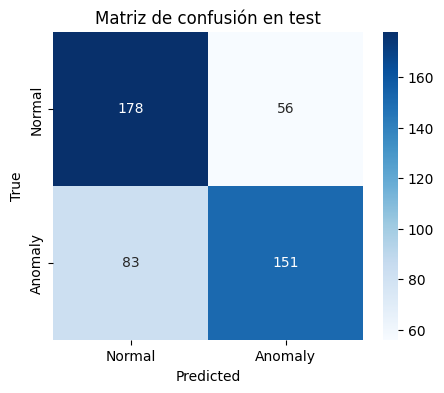

In [45]:
# Matriz de confusión
cm = confusion_matrix(test_labels, test_preds)
tn, fp, fn, tp = cm.ravel()

# Cálculo de tasas
fp_rate = fp / (fp + tn)
fn_rate = fn / (fn + tp)

print(f"🚨 Tasa de falsos positivos (FP rate): {fp_rate:.4f}")
print(f"⚠️ Tasa de falsos negativos (FN rate): {fn_rate:.4f}")

# Mostrar matriz de confusión
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Normal", "Anomaly"], yticklabels=["Normal", "Anomaly"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Matriz de confusión en test")
plt.show()

**¿Qué representan estas métricas?**
* **Accuracy**: qué porcentaje de imágenes fueron clasificadas correctamente.

* **FP Rate**: cuántos sanos fueron mal clasificados como enfermos.

* **FN Rate**: cuántos enfermos fueron mal clasificados como sanos (esto es grave en salud 🧑‍⚕️).

